https://firms.modaps.eosdis.nasa.gov/api/country/ map key: ca021337806597dad23dd6e6859eeed4

In [2]:
from scipy.ndimage import binary_dilation, binary_erosion, label
from skimage.measure import find_contours
from shapely.geometry import Polygon
import geopandas as gpd
import numpy as np
import xarray as xr
import fsspec
import requests
import pandas as pd

In [3]:
def get_viirs_data(date_list, api_key, bbox, path):
    '''
    Connect with FIRMS API to access VIIRS detection data from specific dates and areas
    
    :param date_list: list, each date encoded in '%Y-%m-%d'
    :param api_key: str, from NASA email
    :param bbox: str, bbox of the region of interest
    :param path: str, path of export location
    '''
    
    base_url = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/'

    for date in date_list:
        url = f'{base_url}{api_key}/VIIRS_SNPP_NRT/{bbox}/1/{date}'
        
        fname = path + 'VIIRS_' + date + '.csv'
        
        response = requests.get(url)
        with open(fname, 'wb') as f:
            f.write(response.content)

In [4]:
api_key = 'ca021337806597dad23dd6e6859eeed4'
bbox = "-124.848974,24.396308,-66.885444,49.384358"
path = '/Users/adamhunter/Documents/school projs/firenet/data/viirs_data/'
dates_2023 = pd.date_range(start='2023-08-01', end='2023-08-30').strftime('%Y-%m-%d').tolist()


viirs_data = get_viirs_data(dates_2023, api_key, bbox, path)

KeyboardInterrupt: 

In [5]:
# Load the csv file into a pandas DataFrame
viirs_df = pd.read_csv('/Users/adamhunter/Documents/school projs/firenet/data/viirs_data/VIIRS_2023-08-17.csv')

# Convert the DataFrame to a GeoDataFrame, setting the geometry from the latitude and longitude columns
gdf = gpd.GeoDataFrame(viirs_df, geometry=gpd.points_from_xy(viirs_df.longitude, viirs_df.latitude))
# Filter the GeoDataFrame to only include rows where confidence is 'h'
gdf_high_confidence = gdf[gdf['confidence'] == 'h']


In [9]:
gdf_high_confidence

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,geometry
347,47.91764,-113.56371,367.0,0.37,0.58,2023-08-17,843,N,VIIRS,h,2.0NRT,299.28,6.67,N,POINT (-113.56371 47.91764)
354,47.92310,-113.56429,367.0,0.37,0.58,2023-08-17,843,N,VIIRS,h,2.0NRT,296.68,6.99,N,POINT (-113.56429 47.92310)
406,48.28839,-113.98018,367.0,0.39,0.59,2023-08-17,843,N,VIIRS,h,2.0NRT,297.49,26.82,N,POINT (-113.98018 48.28839)
407,48.28851,-113.98431,367.0,0.39,0.59,2023-08-17,843,N,VIIRS,h,2.0NRT,298.08,9.60,N,POINT (-113.98431 48.28851)
412,48.28953,-113.97885,367.0,0.39,0.59,2023-08-17,843,N,VIIRS,h,2.0NRT,296.53,13.23,N,POINT (-113.97885 48.28953)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,49.23112,-120.03409,367.0,0.51,0.66,2023-08-17,2155,N,VIIRS,h,2.0NRT,299.61,120.94,D,POINT (-120.03409 49.23112)
3331,49.23124,-120.00450,367.0,0.51,0.66,2023-08-17,2155,N,VIIRS,h,2.0NRT,300.86,39.31,D,POINT (-120.00450 49.23124)
3337,49.23340,-120.03651,367.0,0.51,0.66,2023-08-17,2155,N,VIIRS,h,2.0NRT,298.95,12.90,D,POINT (-120.03651 49.23340)
3339,49.23378,-119.99725,367.0,0.51,0.66,2023-08-17,2155,N,VIIRS,h,2.0NRT,299.78,42.80,D,POINT (-119.99725 49.23378)


In [7]:
import folium
# Create a new folium map
m = folium.Map(location=[gdf_high_confidence['latitude'].mean(), gdf_high_confidence['longitude'].mean()], zoom_start=5)

# Add the high confidence points to the map as smaller red dots
for _, r in gdf_high_confidence.iterrows():
    folium.CircleMarker(location=[r['latitude'], r['longitude']], radius=2, color='red', fill=True, fill_color='red').add_to(m)

m  # Display the map



In [16]:
def open_dataset(file_path):
    """
    Open a dataset from a file path.
    """

    f = fsspec.open(file_path)
    ds = xr.open_dataset(f.open())
    return ds

def preprocess_data(ds):
    """
    Preprocess the data to remove NaN values and convert to a numpy array.
    """
    arr = ds['bool']  # Extract the 'bool' data from the dataset
    arr.data = np.nan_to_num(arr.data)  # Replace NaN values with zero
    return arr

def perform_dilation_erosion(arr):
    """
    Perform dilation and erosion on the data to remove small features and fill 1 and 2 pixel holes.
    Structuring element could be made smaller or larger to fill smaller or larger holes.
    """
    structuring_element = np.ones((2, 2), bool)
    dilated = binary_dilation(arr.data, structure=structuring_element)
    eroded = binary_erosion(dilated, structure=structuring_element)
    return eroded

def label_features(eroded):
    """
    Label the separate connected features/components in the data.
    """
    labeled_array, num_features = label(eroded)
    return labeled_array, num_features

def create_polygons(labeled_array, num_features, ds):
    """
    Create contours from the labeled features then create pairs of lat/lons for each contour point.
    These paired arrays are zipped to create each polygon.
    
    """
    polygons = []
    for i in range(1, num_features + 1):
        feature = labeled_array == i
        contours = find_contours(feature, 0.5)
        for contour in contours:
            feature_lats = ds.y.values[contour[:, 0].astype(int)]
            feature_lons = ds.x.values[contour[:, 1].astype(int)]
            polygons.append(Polygon(zip(feature_lons, feature_lats)))
    return polygons

def convert_to_geojson(polygons):
    """
    Create gdf from polygons, then create geojson from gdf.
    """
    gdf = gpd.GeoDataFrame(geometry=polygons)
    geojson = gdf.to_json()
    return geojson

def process_file(file_path):
    ds = open_dataset(file_path)
    arr = preprocess_data(ds)
    eroded = perform_dilation_erosion(arr)
    labeled_array, num_features = label_features(eroded)
    polygons = create_polygons(labeled_array, num_features, ds)
    geojson = convert_to_geojson(polygons)
    return geojson, arr, ds

In [17]:
file_path = "/Users/adamhunter/Downloads/VIIRS_Rasterized_2021-08-11_8_bool.nc"
geojson, arr, ds = process_file(file_path)
print(geojson)

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-106.48746055143981, 45.771876383869156], [-106.49303634625423, 45.771876383869156], [-106.49861214106865, 45.771876383869156], [-106.49861214106865, 45.777452178683575], [-106.49303634625423, 45.78302797349799], [-106.49303634625423, 45.777452178683575], [-106.48746055143981, 45.777452178683575], [-106.48746055143981, 45.771876383869156], [-106.48746055143981, 45.771876383869156]]]}}, {"id": "1", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-106.3313382966362, 45.777452178683575], [-106.33691409145062, 45.777452178683575], [-106.3313382966362, 45.78302797349799], [-106.3313382966362, 45.777452178683575], [-106.3313382966362, 45.777452178683575]]]}}, {"id": "2", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[-106.49861214106865, 45.76072479424033], [-106.50418793588

In [18]:
ds

<xarray.Dataset>
Dimensions:      (x: 89, y: 54)
Coordinates:
  * x            (x) float64 -106.7 -106.7 -106.7 ... -106.2 -106.2 -106.2
  * y            (y) float64 45.78 45.78 45.77 45.77 ... 45.5 45.5 45.49 45.49
Data variables:
    spatial_ref  int64 ...
    bool         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

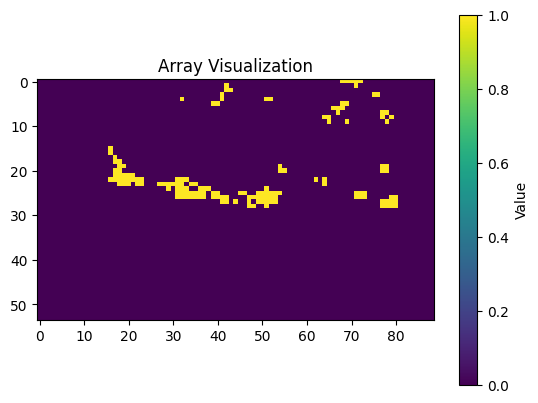

In [19]:
import matplotlib.pyplot as plt

# Plot the array
plt.imshow(arr)
plt.colorbar(label='Value')
plt.title('Array Visualization')
plt.show()


In [20]:
# Import folium for map visualization
import folium

# Create a map centered around the data
m = folium.Map(location=[45.7836, -106.3450], zoom_start=9)

# Add the GeoJSON data to the map
folium.GeoJson(geojson).add_to(m)

# Display the map
m
